In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib

from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_jac_hvp_fun

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

In [3]:
n_obs = 3
k_approx = 5
n_loci = 12

# VB parameters

In [4]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [5]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = True)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (12, 5, 2) (lb=0.0, ub=1000000.0)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (3, 4) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (3, 4) (lb=0.0001, ub=inf)


In [6]:
vb_params_free = vb_params_paragami.flatten(vb_params_dict, free = True)

# The target beta distributions

In [7]:
stick_betas = np.array(np.exp(onp.random.randn(n_obs, k_approx - 1, 2)))

In [8]:
import scipy as osp

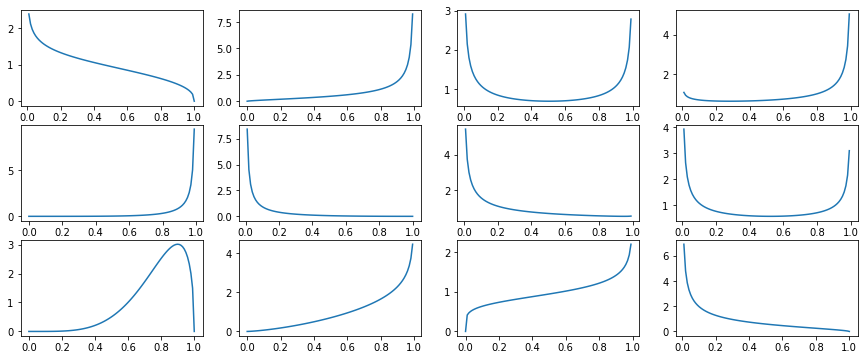

In [9]:
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots(n_obs, k_approx-1, figsize=(15, 6))

for n in range(stick_betas.shape[0]): 
    for k in range(stick_betas.shape[1]): 
        beta_pdf = osp.stats.beta.pdf(x, 
                                      stick_betas[n, k, 0], 
                                      stick_betas[n, k, 1])
        ax[n, k].plot(x, beta_pdf)

# Optimize logitnormal sticks 

We use the method of moments

In [10]:
logitnorm_stick_params_paragami = vb_params_paragami['ind_admix_params']
logitnorm_stick_params_dict = vb_params_dict['ind_admix_params']

In [11]:
stick_params_dict, out = s_optim_lib.convert_beta_sticks_to_logitnormal(stick_betas, 
                                       logitnorm_stick_params_dict,
                                       logitnorm_stick_params_paragami, 
                                       gh_loc, gh_weights)

In [12]:
# the residual
out.fun

array(0.00330349)

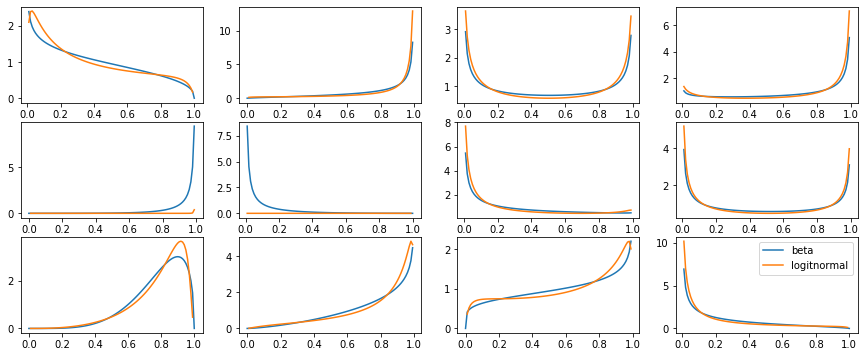

In [13]:
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots(n_obs, k_approx-1, figsize=(15, 6))

for n in range(stick_betas.shape[0]): 
    for k in range(stick_betas.shape[1]): 
        beta_pdf = osp.stats.beta.pdf(x, 
                                      stick_betas[n, k, 0], 
                                      stick_betas[n, k, 1])
        
        logit_x = sp.special.logit(x)
        loc = stick_params_dict['stick_means'][n,k]
        scale = 1 / np.sqrt(stick_params_dict['stick_infos'][n,k])
        logitnormal_pdf = osp.stats.norm.pdf(logit_x, loc = loc, scale = scale) * \
                            1 / (x * (1 - x))
        
        ax[n, k].plot(x, beta_pdf, label = 'beta')
        ax[n, k].plot(x, logitnormal_pdf, label = 'logitnormal')
        

ax[n, k].legend()